In [1]:
# Run in python console
import nltk

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt


# Enable logging for gensim - optional
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

#nltk.download('stopwords')
# nltk.download('punkt') 
# nltk.download('averaged_perceptron_tagger')

# NLTK Stop words
from nltk.corpus import stopwords

C:\Users\KYH\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#불용단어 준비
stop_words = stopwords.words('english')
stop_words.extend(['http','https','make','captain','trailer','theater','ticket','studio','marvel','captainmarvel','good','www','review','bad','weekend','galaxy','avengers','war','marvel','watch','movie','get','time','film','see','new','avenger','go','office','box','infinity']) #여기는 우리가 불용단어 추가하면 된다.
# print(stop_words)

In [3]:
# Import Dataset
def to_table(filename):
    with open(filename, 'r',encoding='UTF8') as apple:
        a = []
        for apps in apple.readlines():
            b = (apps.strip())
            b = b.strip('.,?!;-')
            a.append(b)
            line_list = []
            for line in a:
                line = line.strip('.,?!;-')
                line_list += line.split()
    return line_list

df = to_table('Captain+Marvel100.txt')
# print(df)

In [4]:
tmp = []
for i in df:
    i = i.strip('.,?!;-').lower()
    texts = nltk.word_tokenize(i)
    tmp += nltk.pos_tag(texts)

# print(tmp)

In [5]:
# http://sens.tistory.com/454 참조, 형태소따라 나누기
def pos_extractor(parsed):

    noun_list = []
    adj_list = []
    verb_list = []
    nav_list = []
    adv_list = []

    for i in parsed:

        if i[1] in ['NN', 'NNS', 'NNP', 'NNPS']:
            noun_list.append(i[0])
            nav_list.append(i[0])
        elif i[1] in ['JJ', 'JJR', 'JJS']:
            adj_list.append(i[0])
            nav_list.append(i[0])
        elif i[1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            verb_list.append(i[0])
            nav_list.append(i[0])
        elif i[1] == ['RB', 'RBR', 'RBS']:
            adv_list.append(i[0])
            nav_list.append(i[0])

        else:
            pass

    return [nav_list, noun_list, adj_list,
            verb_list]  

In [6]:
# print(pos_extractor(tmp))

data_words = list(pos_extractor(tmp)[0])
# print(data_words)

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)  # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# print(data_words)

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
data_words_nostops = remove_stopwords(data_words)

In [10]:
# Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams=make_trigrams(data_words_nostops)
# print(data_words_trigrams)

In [11]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en (cmd에서 실행)
nlp = spacy.load('en', disable=['parser', 'ner'])

In [12]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print(data_lemmatized)
# Remove Stop Words
data_lemmatized2 = remove_stopwords(data_lemmatized)
# print(data_lemmatized2)

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized2)
# print(id2word)

# Create Corpus
texts = data_lemmatized2
for i in texts:
    try:
        i == [] or ['\n']
        texts.remove(i)
    except IndexError:
        pass

list_a = []

for i in texts:
    try:
        list_a.append(i[0])
    except IndexError:
        pass

In [14]:
# Term Document Frequency
corpus = [id2word.doc2bow(list_a) for text in texts]
# print(corpus)
# print(corpus[2]) # 일부가 출력되었음
 
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [29]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
id2word=id2word,
num_topics=5,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto',
per_word_topics=True)

KeyboardInterrupt: 

In [16]:
# Print the Keyword in the 10 topics
# carol과 brie는 주인공 이름입니다.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"woman" + 0.009*"mcu" + 0.008*"brie" + 0.008*"smile" + 0.007*"carol" '
  '+ 0.007*"man" + 0.007*"know" + 0.006*"love" + 0.006*"wonder" + '
  '0.006*"hero"'),
 (1,
  '0.011*"woman" + 0.010*"brie" + 0.009*"larson" + 0.008*"smile" + '
  '0.008*"look" + 0.008*"carol" + 0.007*"man" + 0.007*"know" + 0.007*"love" + '
  '0.006*"mcu"'),
 (2,
  '0.011*"smile" + 0.009*"mcu" + 0.009*"man" + 0.009*"woman" + 0.008*"larson" '
  '+ 0.008*"look" + 0.008*"know" + 0.008*"carol" + 0.006*"brie" + '
  '0.006*"people"'),
 (3,
  '0.013*"woman" + 0.008*"brie" + 0.008*"man" + 0.008*"mcu" + 0.007*"look" + '
  '0.007*"smile" + 0.007*"know" + 0.007*"carol" + 0.007*"hero" + '
  '0.007*"larson"'),
 (4,
  '0.012*"woman" + 0.009*"man" + 0.008*"know" + 0.008*"carol" + 0.007*"larson" '
  '+ 0.006*"mcu" + 0.006*"comic" + 0.006*"look" + 0.006*"love" + 0.006*"brie"'),
 (5,
  '0.011*"woman" + 0.009*"mcu" + 0.009*"man" + 0.008*"larson" + 0.007*"look" + '
  '0.007*"know" + 0.007*"smile" + 0.006*"carol" + 0.006*"

In [17]:
# Compute Perplexity(모델 난이도)
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.


Perplexity:  -7.091126132750157


In [25]:
# Compute Coherence Score(일관성 점수)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized2, dictionary=id2word, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.8603838675859363


In [19]:
# Visualize the topics(대화형차트) - 토픽과 키워드 검사
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      10.053459        1       1  0.000768  0.001360
1      10.048953        1       2 -0.002472 -0.001359
3      10.046391        1       3  0.001807 -0.001801
6      10.026473        1       4  0.002768 -0.000650
2      10.009623        1       5  0.000468  0.004291
5       9.997628        1       6 -0.001098  0.001024
0       9.985105        1       7  0.000084 -0.001132
8       9.977612        1       8 -0.002274 -0.000281
7       9.956301        1       9  0.001947 -0.000933
9       9.898456        1      10 -0.001997 -0.000520, topic_info=     Category          Freq       Term         Total  loglift  logprob
term                                                                  
255   Default  8.455120e+05       brie  8.455120e+05  30.0000  30.0000
176   Default  8.455100e+05      smile  8.455100e+05  29.0000  29.0000
138   Default  8.870910e+05        mcu  8.870910e+05  28.0000  28.0000
91    Default  6.791830e+05       love  6.791830e+05  27.0000  27.0000
133   Default  4.712650e+05     female  4.712650e+05  26.0000  26.0000
172   Default  1.247465e+06      woman  1.247465e+06  25.0000  25.0000
256   Default  7.900660e+05     larson  7.900660e+05  24.0000  24.0000
709   Default  2.910790e+05      story  2.910790e+05  23.0000  23.0000
28    Default  3.187970e+05       hope  3.187970e+05  22.0000  22.0000
19    Default  4.158240e+05     shazam  4.158240e+05  21.0000  21.0000
193   Default  4.712690e+05       talk  4.712690e+05  20.0000  20.0000
34    Default  5.682890e+05     spider  5.682890e+05  19.0000  19.0000
187   Default  5.128430e+05       come  5.128430e+05  18.0000  18.0000
36    Default  3.742360e+05      black  3.742360e+05  17.0000  17.0000
7     Default  4.435430e+05       take  4.435430e+05  16.0000  16.0000
33    Default  8.870860e+05        man  8.870860e+05  15.0000  15.0000
73    Default  2.633570e+05       next  2.633570e+05  14.0000  14.0000
233   Default  5.960150e+05       life  5.960150e+05  13.0000  13.0000
169   Default  3.603810e+05     danver  3.603810e+05  12.0000  12.0000
69    Default  5.682880e+05        day  5.682880e+05  11.0000  11.0000
206   Default  3.742390e+05        omg  3.742390e+05  10.0000  10.0000
29    Default  3.187990e+05    release  3.187990e+05   9.0000   9.0000
104   Default  4.019630e+05      thank  4.019630e+05   8.0000   8.0000
10    Default  4.158200e+05      thing  4.158200e+05   7.0000   7.0000
192   Default  3.049390e+05    episode  3.049390e+05   6.0000   6.0000
323   Default  5.682920e+05      comic  5.682920e+05   5.0000   5.0000
25    Default  8.039240e+05       look  8.039240e+05   4.0000   4.0000
300   Default  2.079100e+05      check  2.079100e+05   3.0000   3.0000
835   Default  2.772150e+05       give  2.772150e+05   2.0000   2.0000
225   Default  4.989890e+05  superhero  4.989890e+05   1.0000   1.0000
...       ...           ...        ...           ...      ...      ...
70    Topic10  4.767619e+04       wait  4.158237e+05   0.1470  -5.4588
104   Topic10  4.619721e+04      thank  4.019631e+05   0.1494  -5.4903
233   Topic10  6.624525e+04       life  5.960153e+05   0.1159  -5.1298
46    Topic10  8.696627e+04      carol  8.039276e+05   0.0888  -4.8577
138   Topic10  9.483489e+04        mcu  8.870914e+05   0.0770  -4.7710
171   Topic10  6.395667e+04     wonder  5.821558e+05   0.1043  -5.1650
375   Topic10  4.127383e+04    excited  3.603791e+05   0.1459  -5.6030
69    Topic10  6.180298e+04        day  5.682886e+05   0.0941  -5.1992
838   Topic10  3.803929e+04        guy  3.326603e+05   0.1443  -5.6846
193   Topic10  5.091038e+04       talk  4.712696e+05   0.0874  -5.3931
255   Topic10  8.507688e+04       brie  8.455126e+05   0.0164  -4.8796
135   Topic10  2.473273e+04       male  2.079127e+05   0.1838  -6.1151
350   Topic10  3.736397e+04      great  3.326606e+05   0.1264  -5.7025
225   Topic10  5.292704e+04  superhero  4.9

In [20]:
# Show Topics
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('woman', 0.011300987),
   ('mcu', 0.009198503),
   ('brie', 0.008237888),
   ('smile', 0.0076757814),
   ('carol', 0.0068563297),
   ('man', 0.0067384737),
   ('know', 0.006633378),
   ('love', 0.0057765837),
   ('wonder', 0.005764253),
   ('hero', 0.0057293405)]),
 (1,
  [('woman', 0.011162671),
   ('brie', 0.010094856),
   ('larson', 0.008690313),
   ('smile', 0.008005308),
   ('look', 0.007699395),
   ('carol', 0.0076809227),
   ('man', 0.007162863),
   ('know', 0.0065583964),
   ('love', 0.006511929),
   ('mcu', 0.006137253)]),
 (2,
  [('smile', 0.010996769),
   ('mcu', 0.009444941),
   ('man', 0.00873828),
   ('woman', 0.008670161),
   ('larson', 0.008338383),
   ('look', 0.008037653),
   ('know', 0.007752306),
   ('carol', 0.007548545),
   ('brie', 0.0062462483),
   ('people', 0.006136365)]),
 (3,
  [('woman', 0.013175084),
   ('brie', 0.008396283),
   ('man', 0.0078119747),
   ('mcu', 0.007589144),
   ('look', 0.0074951337),
   ('smile', 0.007274425),
   ('know', 0.0072

In [21]:
# k의 수(최적의 토픽 수) 를 찾아보기 
#밑의 함수는 여러 LDA 모델을 교육하고 모델 및 해당하는 일관성 점수를 알려준다.
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
 
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
 
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics,random_state=100,
                                              update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
 
    return model_list, coherence_values

In [24]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized2, start=2, limit=10, step=3)

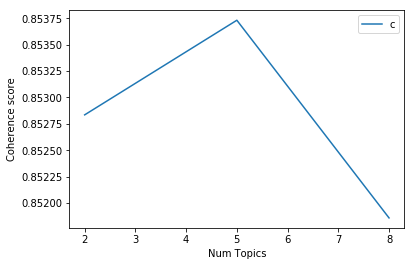

In [28]:
# Show graph
limit=10; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores 가장 일관성 높은 모델 선택
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.8528
Num Topics = 5  has Coherence Value of 0.8537
Num Topics = 8  has Coherence Value of 0.8519


In [33]:
# Select the model and print the topics
optimal_model = model_list[2] #여긴 경우에 따라 고치기
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.011*"woman" + 0.009*"mcu" + 0.008*"brie" + 0.008*"smile" + 0.007*"carol" '
  '+ 0.007*"know" + 0.006*"man" + 0.006*"love" + 0.006*"wonder" + '
  '0.006*"spider" + 0.006*"hero" + 0.006*"life" + 0.006*"larson" + '
  '0.006*"look" + 0.006*"people" + 0.005*"superhero" + 0.005*"danver" + '
  '0.005*"say" + 0.005*"fan" + 0.004*"shazam"'),
 (1,
  '0.011*"woman" + 0.010*"brie" + 0.009*"larson" + 0.008*"smile" + '
  '0.008*"look" + 0.008*"carol" + 0.007*"love" + 0.007*"man" + 0.007*"know" + '
  '0.006*"mcu" + 0.006*"hero" + 0.006*"wonder" + 0.005*"superhero" + '
  '0.005*"life" + 0.005*"day" + 0.005*"spider" + 0.005*"week" + 0.005*"think" '
  '+ 0.005*"year" + 0.004*"shazam"'),
 (2,
  '0.011*"smile" + 0.009*"mcu" + 0.008*"woman" + 0.008*"man" + 0.008*"larson" '
  '+ 0.008*"look" + 0.008*"know" + 0.008*"carol" + 0.006*"brie" + 0.006*"love" '
  '+ 0.006*"people" + 0.006*"comic" + 0.005*"week" + 0.005*"day" + '
  '0.005*"hero" + 0.005*"life" + 0.005*"gon" + 0.005*"year" + 0.005*"talk" + 